# Sandbox
Notebook to test code before real implementation

In [1]:
################ ONLY PYTHON 2 #########################
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations, chain, product
import argparse
import time
import os
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics
import pandas as pd
import psutil
import pickle
from decagon.deep.optimizer import DecagonOptimizer
from decagon.deep.model import DecagonModel
from decagon.deep.minibatch import EdgeMinibatchIterator
from decagon.utility import rank_metrics, preprocessing

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import time
import os
import psutil
import pickle
from pybdm import BDM
from pybdm.utils import decompose_dataset
from pybdm.partitions import PartitionIgnore
from joblib import Parallel, delayed
from joblib import parallel_backend
from data.algorithms import PerturbationExperiment, NodePerturbationExperiment
import math
import datetime as dt
from itertools import product
from decagon.utility import preprocessing

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## New training_results draft

In [4]:
filename = './results_training/sandboxish'
with open(filename, 'rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")
print('\n')
print('Total Time:',datetime.timedelta(seconds=time))
print('Virtual Memory:',vms*1e-9,'Gb')
print('RSS Memory:',rss*1e-9,'Gb')

val_auc Imported successfully
train_acc Imported successfully
test_scores Imported successfully
epoch Imported successfully
val_acc Imported successfully
val_auprc Imported successfully
time Imported successfully
vms Imported successfully
rss Imported successfully


Total Time: 0:05:01.560198
Virtual Memory: 3.327901696 Gb
RSS Memory: 0.385654784 Gb


In [5]:
print(np.shape(val_auc),'val_auc')
print(np.shape(val_auprc),'val_auprc')
print(np.shape(val_acc),'val_acc')
print(np.shape(train_acc),'train_acc')
print(np.shape(test_scores),'test_scores')

(10, 10) val_auc
(10, 10) val_auprc
(10, 10) val_acc
(10, 10) train_acc
(10, 3) test_scores


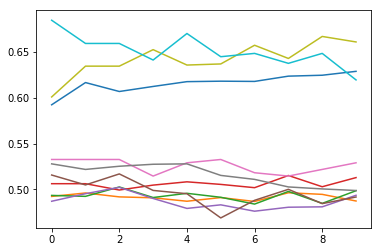

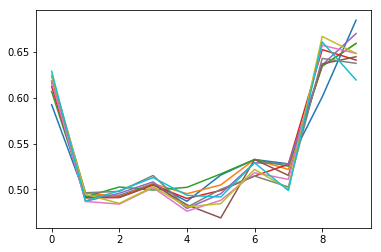

In [15]:
fig1 = figure()
plot(val_acc)
fig1.show()
fig2=figure()
plot(val_acc.transpose())
fig2.show()

## Trying to create negative test,val and train datasets

In [ ]:
# Creation of random adj matrix
X=sp.random(100,100,density=0.15).todense().astype(bool).astype(int)
val_test_size = 0.15

In [ ]:
# Choosing positive and negative entries
indexes = [range(k) for k in X.shape]
idx = np.array([ x for x in product(*indexes) ],dtype=int)
print(np.shape(idx))
positive = np.array([ x for x in zip(np.nonzero(X)[0],np.nonzero(X)[1])])
print(np.shape(positive))
mask = np.invert((idx[:, None] == positive).all(-1).any(-1))
negative = idx[mask]
print(np.shape(negative))

In [ ]:
# Define number of train, test and val instances
num_test = max(20, int(np.floor(positive.shape[0] * val_test_size)))
num_val = max(20, int(np.floor(positive.shape[0] * val_test_size)))
num_train = positive.shape[0]-num_test-num_val
print(num_test,num_val,num_train)

In [ ]:
# Indices for each positive subset
pos_idx = np.arange(np.shape(positive)[0])
edges_idx = np.random.choice(pos_idx,size=num_test+num_val,replace=False)
test_edges_idx = edges_idx[:num_test]
val_edges_idx = edges_idx[num_test:]
train_edges_idx = np.delete(pos_idx,edges_idx)

In [ ]:
val_edges = positive[val_edges_idx]
test_edges = positive[test_edges_idx]
train_edges = positive[train_edges_idx]

In [ ]:
# Indices for each negative subset
neg_idx = np.arange(np.shape(negative)[0])
print(len(neg_idx))
edges_idx = np.random.choice(neg_idx,size=num_test+num_val+num_train,replace=False)
test_edges_false_idx = edges_idx[:num_test]
print(len(test_edges_false_idx))
val_edges_false_idx = edges_idx[num_test:num_val+num_test]
print(len(val_edges_false_idx))
train_edges_false_idx = edges_idx[-num_train:]
print(len(train_edges_false_idx))

In [ ]:
val_false_edges = negative[val_edges_false_idx]
test_false_edges = negative[test_edges_false_idx]
train_false_edges = negative[train_edges_false_idx]

In [ ]:
preprocessing.sparse_to_tuple(sp.random(100,100,density=0.15))